In [184]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib
from skimage import data

import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from prettytable import PrettyTable

# Visualizing dyad

## Compute the Singular Value Decomposition of an image X

In [14]:
X = data.coins()
(m, n) = X.shape

print(f'Size of X: {(m, n)}')

# SVD
(U, s, Vt) = scipy.linalg.svd(X)

print(f"\nFirst 10 singular values of X:")
print(s[:10])

Size of X: (303, 384)

First 10 singular values of X:
[35304.977   6989.3438  4178.8076  3794.253   3003.55    2832.4763
  2683.153   2563.3337  2010.508   1769.5245]


#### Plot different approxiamtion of the dyad

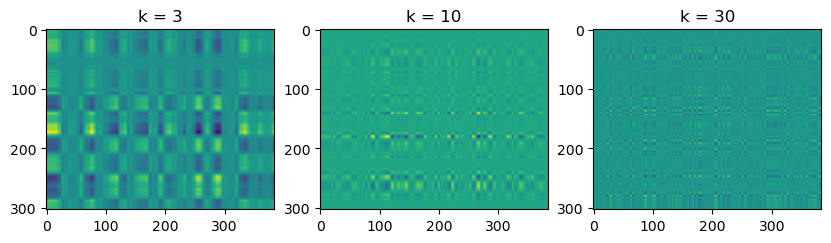

In [38]:
dyads = [0,0,0]
dyads[0] = np.outer(U[:,3], Vt[3,:]) * s[3]
dyads[1] = np.outer(U[:,10], Vt[10,:]) * s[10]
dyads[2] = np.outer(U[:,30], Vt[30,:]) * s[30]

plt.figure(figsize=(10, 3))
plt.subplot(1,3,1)
plt.imshow(dyads[0])
plt.title("k = 3")
plt.subplot(1,3,2)
plt.imshow(dyads[1])
plt.title("k = 10")
plt.subplot(1,3,3)
plt.imshow(dyads[2])
plt.title("k = 30")
plt.show()

#### Plot of the singular values

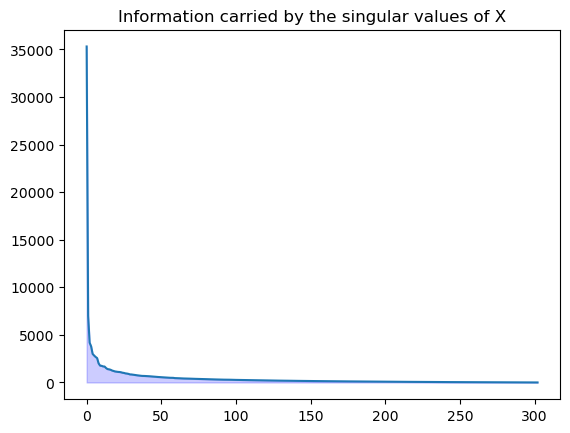

In [25]:
xs = np.arange(0,len(s))
plt.plot(xs, s)
plt.fill_between(xs, s, color= "b", alpha= 0.2)
plt.title("Information carried by the singular values of X")
plt.show()

## Approximation of X with increasing number of σ

with more singular values the image is closer to the original

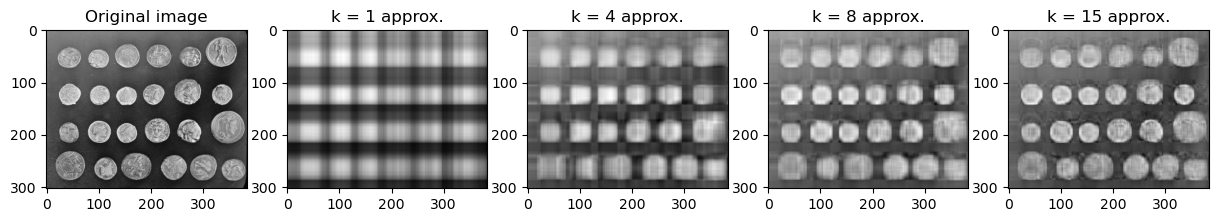

In [42]:
plt.figure(figsize=(15,5))
plt.subplot(1,5,1)
plt.imshow(X, cmap="gray")
plt.title("Original image")

j = 0
for k in [1,4,8,15]:
    X_p = np.sum([np.outer(U[:,i], Vt[i,:]) * s[i] for i in range(k)], axis=0)
    j += 1
    plt.subplot(1,5,j+1)
    plt.imshow(X_p, cmap="gray")
    plt.title(f"k = {k} approx.")

plt.show()

#### Computing Approximation Error and Compression Factor

In [43]:
X_k = np.zeros(X.shape)
k = range(1,300)
cs = np.zeros(len(k))
err_rels = np.zeros(len(k))

for i in k:
    X_k = X_k + np.outer(U[:,i], Vt[i,:]) * s[i]
    err_rels[i-1] = np.linalg.norm(np.subtract(X,X_k) , "fro") / np.linalg.norm(X, "fro")
    cs[i-1] = 1 - ((i*(m+n+1))/(m*n))

Plots

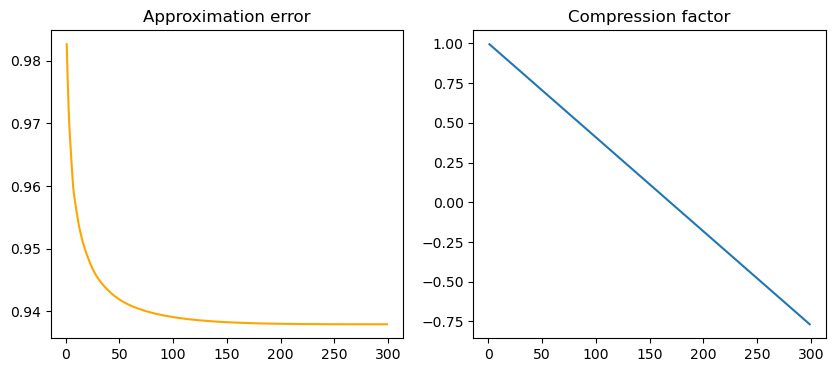

In [44]:
plt.figure(figsize=(10, 4))
fig2 = plt.subplot(1, 2, 1)
fig2.plot(k,err_rels, c="orange")
fig2.set_title("Approximation error")

fig1 = plt.subplot(1, 2, 2)
fig1.plot(k,cs)
fig1.set_title("Compression factor")

plt.show()

computing k so that ck = 0

In [46]:
k = (m*n)/(m+n+1)
print(f"k for compression factor = 0: {int(k-1)}")
print(f"compression factor for k = {int(k-1)}: {cs[int(k-1)]:.5f}")
print(f"error for k = {int(k-1)}: {err_rels[int(k-1)]:.5f}")


k for compression factor = 0: 168
compression factor for k = 168: 0.00069
error for k = 168: 0.93813


Does it make sense that ck = 0 for k < than 300? (No)  
The approximation error for ck = 0 should be zero because there is no approximation, so no error

# Classification of MNIST digits with SVD

#### Load data

In [185]:
data = pd.read_csv('../data/mnist_train.csv')

data = np.array(data)

X = data[:, 1:]
Y = data[:, 0]

print(X.shape, Y.shape)

(42000, 784) (42000,)


##### visualizer function

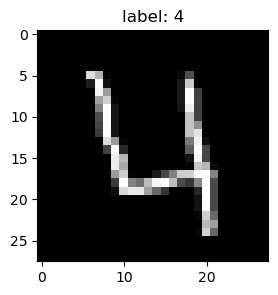

In [116]:
def visualize(i, X, Y):
    img = np.array(X[i, :])
    img = img.reshape((28, 28))
    plt.figure(figsize=(3,3))
    plt.imshow(img, cmap='gray')
    plt.title(f"label: {Y[i]}")
    plt.show()

visualize(3, X, Y)

## 3s and 4s classification

#### Train/test split

In [101]:
Y34 = Y[(Y == 3) | (Y == 4)]
X34 = X[(Y == 3) | (Y == 4), :]

# train test split
x_train, x_test, y_train, y_test = train_test_split(X34, Y34, test_size=0.20, random_state=33)

# filter only 3s and 4s
x1 = x_train[y_train == 3]  # 80% of all 3s
x2 = x_train[y_train == 4]  # 80% of all 4s

c1 = 3
c2 = 4

print(f"x1 shape: {x1.shape}, x2 shape: {x2.shape}")

x1 shape: (3493, 784), x2 shape: (3245, 784)


#### SVD decomposition (training)

In [102]:
U1, s1, Vt1 = np.linalg.svd(x1, full_matrices=False)
U2, s2, Vt2 = np.linalg.svd(x2, full_matrices=False)

# U1, U2 = U1.T, U2.T
U1, U2 = Vt1.T, Vt2.T
print(U1.shape)
print(U2.shape)

(784, 784)
(784, 784)


#### Inference

(784, 784)
(784,)
The instance 1209 of the test set is classified as 4, (true label was 4)
True label 4
Distance from C1: 3.764510052388172e-12, distance from C2: 3.3174903347961288e-12


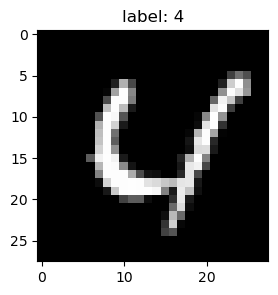

In [117]:
i = random.randint(0,len(x_test))
x = x_test[i, :]
y = y_test[i]

print(U1.shape)
print(x.shape)

x1b = U1 @ (U1.T @ x)
x2b = U2 @ (U2.T @ x)

# distances
d1 = np.linalg.norm((x-x1b), 2)
d2 = np.linalg.norm((x-x2b), 2)

if d1 < d2:
    print(f"The instance {i} of the test set is classified as {c1}, (true label was {y})")
    print(f"Distance from C1: {d1}, distance from C2: {d2}")
    visualize(i, x_test, y_test)
else:
    print(f"The instance {i} of the test set is classified as {c2}, (true label was {y})")
    print(f"True label {y}")
    print(f"Distance from C1: {d1}, distance from C2: {d2}")
    visualize(i, x_test, y_test)

##### can_classify returns True if the SVD method is capable of correctly classifying an instance given its true label

In [104]:
def can_classify(x, y_true, U1, U2, C1, C2):
    
    x1b = U1 @ (U1.T @ x)
    x2b = U2 @ (U2.T @ x)

    d1 = np.linalg.norm((x-x1b), 2)
    d2 = np.linalg.norm((x-x2b), 2)

    if d1 <= d2:
        if y_true == C1:
            return True
        elif y_true == C2:
            return False
        else:
            print(f"classified as {c1}, (true label was {y})")
            print(f"Distance from C1: {d1}, distance from C2: {d2}")
    elif  d1 > d2:
        if y_true == C1:
            return False
        elif y_true == C2:
            return True  
        else:
            print(f"classified as {c1}, (true label was {y})")
            print(f"Distance from C1: {d1}, distance from C2: {d2}")

<!-- #### Misclassification error (testing) -->

#### Misclassification rate (testing)

In [105]:
classifications = np.array([can_classify(x, y, U1, U2, c1, c2) for x,y in list(zip(x_test, y_test))])
assert len(classifications == len(x_test))
correct_classifications = len(classifications[classifications == True])
MR = 1 - correct_classifications / len(x_test)

print(f"Total elements: {len(x_test)}, correctly classified elements: {correct_classifications}, MR: {MR}")

Total elements: 1685, correctly classified elements: 1630, MR: 0.03264094955489616


## Classification for more digits pairs

#### classification function for 2 classes

In [215]:
def SVD_MNIST_classification(c1, c2, rand_inf=True):
    X12 = X[(Y == c1) | (Y == c2), :]
    Y12 = Y[(Y == c1) | (Y == c2)]

    # train test split
    x_train, x_test, y_train, y_test = train_test_split(X12, Y12, test_size=0.20, random_state=33)

    x1 = x_train[y_train == c1]
    x2 = x_train[y_train == c2]
    
    U1, _, Vt1 = np.linalg.svd(x1, full_matrices=False)
    U2, _, Vt2 = np.linalg.svd(x2, full_matrices=False)

    # U1, U2 = U1.T, U2.T
    U1, U2 = Vt1.T, Vt2.T

    if rand_inf:
        # random inference test
        i = random.randint(0,len(x_test))
        x = x_test[i, :]
        y = y_test[i]
        x1b = U1 @ (U1.T @ x)
        x2b = U2 @ (U2.T @ x)
    
        # distances
        d1 = np.linalg.norm((x-x1b), 2)
        d2 = np.linalg.norm((x-x2b), 2)
    
        print("Example inference:")
        if d1 < d2:
            print(f"The instance {i} of the test set is classified as {c1}, (true label was {y})")
        else:
            print(f"The instance {i} of the test set is classified as {c2}, (true label was {y})")
        print(f"Distance from C1: {d1}, distance from C2: {d2}")
        visualize(i, x_test, y_test)

    # misclassificaiton rate
    classifications = np.array([can_classify(x, y, U1, U2, c1, c2) for x,y in list(zip(x_test, y_test))])
    correct_classifications = len(classifications[classifications == True])
    MR = 1 - correct_classifications / len(x_test)

    print("---------------------------------------------------------------------------------------")
    print(f"Total elements ({c1}, {c2}): {len(x_test)}, correctly classified elements: {correct_classifications}, MR: {MR}")

In [ ]:
def SVD_MNIST_MR(c1, c2):
    X12 = X[(Y == c1) | (Y == c2), :]
    Y12 = Y[(Y == c1) | (Y == c2)]

    # train test split
    x_train, x_test, y_train, y_test = train_test_split(X12, Y12, test_size=0.20, random_state=33)

    x1 = x_train[y_train == c1]
    x2 = x_train[y_train == c2]
    
    U1, _, Vt1 = np.linalg.svd(x1, full_matrices=False)
    U2, _, Vt2 = np.linalg.svd(x2, full_matrices=False)

    # U1, U2 = U1.T, U2.T
    U1, U2 = Vt1.T, Vt2.T

    # misclassificaiton rate
    classifications = np.array([can_classify(x, y, U1, U2, c1, c2) for x,y in list(zip(x_test, y_test))])
    correct_classifications = len(classifications[classifications == True])
    MR = 1 - correct_classifications / len(x_test)

    return MR

#### 8 and 9 are two very similar digits, let's see how SVD behaves here

Example inference:
The instance 1137 of the test set is classified as 8, (true label was 8)
Distance from C1: 3.907420389169964e-12, distance from C2: 3.931973205310564e-12


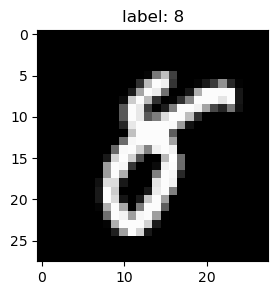

---------------------------------------------------------------------------------------
Total elements (8, 9): 1651, correctly classified elements: 1446, MR: 0.12416717141126588


In [126]:
SVD_MNIST_classification(8, 9)

#### 0 and 1 are two very different digits, let's see how SVD behaves here

Example inference:
The instance 106 of the test set is classified as 0, (true label was 0)
Distance from C1: 4.478359084554734e-12, distance from C2: 5.480425022379377e-12


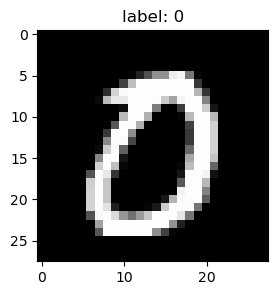

---------------------------------------------------------------------------------------
Total elements (0, 1): 1764, correctly classified elements: 1750, MR: 0.007936507936507908


In [127]:
SVD_MNIST_classification(0, 1)

#### All possible digits pairs

In [167]:
# digits = list(range(10))
# [SVDMNISTClassification(a, b, False) for idx, a in enumerate(digits) for b in digits[idx + 1:]]

MR_perc_matrix = np.empty((10,10), dtype='object')

for i in range(10):
    for j in range(10):
        if i == j:
            MR_perc_matrix[i, j] = "/"
        else:
            MR_perc_matrix[i, j] = str(round((SVD_MNIST_MR(i, j)*100), 2))+"%"

In [168]:
tab = PrettyTable(list(range(10)))
tab.add_rows(MR_perc_matrix[:])

fieldname = '.'
tab._field_names.insert(0, fieldname)  
tab._align[fieldname] = 'c' 
tab._valign[fieldname] = 't' 
for i, _ in enumerate(tab._rows): 
    tab._rows[i].insert(0, i) 
print(tab)

+---+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
| . |   0   |   1    |   2    |   3    |   4    |   5    |   6    |   7    |   8    |   9    |
+---+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
| 0 |   /   | 0.79%  | 6.56%  | 47.2%  | 0.91%  | 9.46%  | 7.19%  | 1.58%  | 9.58%  | 3.97%  |
| 1 | 0.79% |   /    | 3.89%  | 1.77%  | 1.37%  | 1.18%  | 3.74%  | 6.93%  | 26.29% | 0.56%  |
| 2 | 6.56% | 3.89%  |   /    | 10.14% | 2.06%  | 1.38%  | 2.22%  | 3.55%  | 15.9%  |  4.3%  |
| 3 | 47.2% | 1.77%  | 10.14% |   /    | 3.26%  | 13.93% | 1.41%  | 13.82% | 41.53% | 7.03%  |
| 4 | 0.91% | 1.37%  | 2.06%  | 3.26%  |   /    | 2.22%  | 4.08%  | 15.1%  |  9.4%  | 23.79% |
| 5 | 9.46% | 1.18%  | 1.38%  | 13.93% | 2.22%  |   /    | 6.49%  | 3.11%  | 26.65% | 6.64%  |
| 6 | 7.19% | 3.74%  | 2.22%  | 1.41%  | 4.08%  | 6.49%  |   /    | 1.23%  | 35.67% | 1.98%  |
| 7 | 1.58% | 6.93%  | 3.55%  | 13.82% | 15.1%  | 

## Classification for more than 2 classes

#### n-classes classification function 

In [225]:
def SVD_MNIST_n_classification(cs, prettyPrint=False):

    X_filtered = X[np.isin(Y, cs), :]
    Y_filtered = Y[np.isin(Y, cs)]

    # Train-test split
    x_train, x_test, y_train, y_test = train_test_split(
        X_filtered, Y_filtered, test_size=0.20, random_state=33)

    # Prepare a dictionary to store the U matrix of each class
    svd_dict = {}
    for c in cs:
        x_class = x_train[y_train == c]
        U, _, Vt = np.linalg.svd(x_class, full_matrices=False)
        svd_dict[c] = Vt.T

    def classify(x):
        xbs = {c: svd_dict[c] @ (svd_dict[c].T @ x) for c in cs}
        scores = {c: np.linalg.norm(x-xbs[c]) for c in cs}
        
        return min(scores, key=scores.get)


    classifications = np.array([classify(x) for x in x_test])

    correct_classifications = np.sum(classifications == y_test)

    # Misclassification rate (MR)
    MR = 1 - correct_classifications / len(x_test)

    if prettyPrint:
        print(f"Total elements {cs}: {len(x_test)}, correctly classified elements: {correct_classifications}, MR: {round((MR*100), 2)}%")
    else:
        return MR

#### Misclassification rates for n classes classification

In [227]:
# comparison for 2 classes, results should be the same
print("[0,1] digits with multiclass classification, MR:\t", SVD_MNIST_n_classification([0,1], False))
print("[0,1] digits with biclass classification, MR:\t\t", SVD_MNIST_MR(0,1))
print("")

# test with 3 similar digits
SVD_MNIST_n_classification([1,2,4], True)
# test with 3 non similar digits
SVD_MNIST_n_classification([0,8,9], True)
print("")

# test with more digits
SVD_MNIST_n_classification([0,1,2,3], True)
SVD_MNIST_n_classification([2,3,4,5,8], True)
SVD_MNIST_n_classification([4,5,6,7,8,9], True)

[0,1] digits with multiclass classification, MR:	 0.007936507936507908
[0,1] digits with biclass classification, MR:		 0.007936507936507908

Total elements [1, 2, 4]: 2587, correctly classified elements: 2196, MR: 15.11%
Total elements [0, 8, 9]: 2477, correctly classified elements: 2140, MR: 13.61%

Total elements [0, 1, 2, 3]: 3469, correctly classified elements: 2333, MR: 32.75%
Total elements [2, 3, 4, 5, 8]: 4092, correctly classified elements: 3042, MR: 25.66%
Total elements [4, 5, 6, 7, 8, 9]: 4932, correctly classified elements: 3263, MR: 33.84%


From theese results we can see how the number of classes doesn't really affect the MR, or at least not as much as the similarity between digits

# Clustering with PCA

dataset loading

In [9]:
data = pd.read_csv('../data/mnist_train.csv')
data = np.array(data)

X = np.array(data[:, 1:])
Y = np.array(data[:, 0])

print(X.shape, Y.shape)

(42000, 784) (42000,)


train test split

In [10]:
digits = [0,6,9]

mask = (Y == digits[0]) | (Y == digits[1]) | (Y == digits[2])
X069 = X[mask, :]
Y069 = Y[mask]

split = random.randint(1,5)/10
print(f"Random train/test split: {1-split}%/{split}%")
x_train, x_test, y_train, y_test = train_test_split(X069, Y069, test_size=split, random_state=42)

Random train/test split: 0.9%/0.1%


## Computing the PCA

#### PCA function

In [11]:
def my_PCA(X, n_components=2, returnP=False):

    # Center the data (subtract the mean of each feature)
    X_centered = X - np.mean(X, axis=0)

    # Perform SVD on the centered data matrix
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

    # Extract the principal components from Vt (transposed V)
    components = Vt.T[:, :n_components]

    # Project the data onto the principal components
    projected_data = X_centered.dot(components)
    
    if not returnP:
        return projected_data
    else:
        return projected_data, components

# def my_PCA(X, k):
#     cX = np.mean(X, axis=1).reshape((X.shape[0],1))
#     Xc = X - cX
#     U, s, VT = np.linalg.svd(Xc, full_matrices=False)
#     P = U[:,:k].T
#     Zk = P @ X
#     return Zk
#     # return [Zk, P]

def my_PCA_fit(X, p):
    X_centered = X - np.mean(X, axis=0)
    projected_data = X_centered.dot(p)
    
    return projected_data

#### Plotting

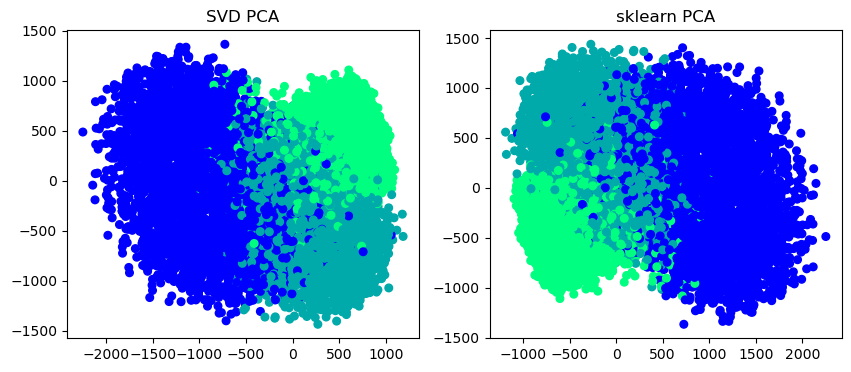

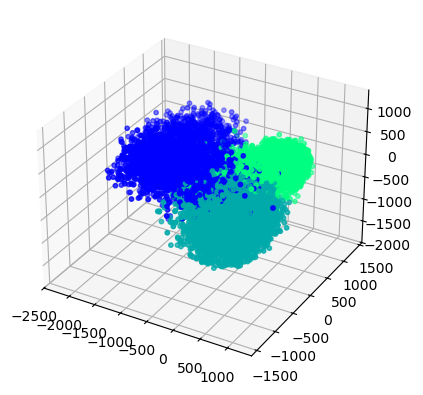

In [12]:
# 2D
# my PCA
Z_train = my_PCA(x_train, 2)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("SVD PCA")
plt.scatter(Z_train[:, 0], Z_train[:, 1], c=y_train, cmap='winter', s=30)

# sklearn PCA
pca = PCA(n_components=2)
Z_train = pca.fit_transform(x_train)
plt.subplot(1,2,2)
plt.title("sklearn PCA")
plt.scatter(Z_train[:, 0], Z_train[:, 1], c=y_train, cmap='winter', s=30)
plt.show()

# 3D
# my PCA
Z_train = my_PCA(x_train, 3)
# plt.subplot(1,4,3)
ax = plt.axes(projection='3d')
ax.scatter3D(Z_train[:, 0], Z_train[:, 1], Z_train[:, 2], c=y_train, cmap='winter', s=10)
plt.show()


## Clusters and centroids

### For each cluster identified by the label, we compute the centroid

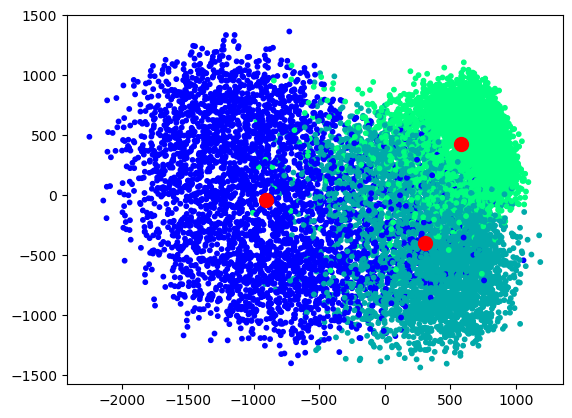

In [13]:
Z_train = my_PCA(x_train, 2)

Z1 = Z_train[y_train == digits[0]]
Z2 = Z_train[y_train == digits[1]]
Z3 = Z_train[y_train == digits[2]]

Z1_centroid = np.mean(Z1, axis=0)
Z2_centroid = np.mean(Z2, axis=0)
Z3_centroid = np.mean(Z3, axis=0)
centroids = np.array([Z1_centroid, Z2_centroid, Z3_centroid])


plt.scatter(Z_train[:, 0], Z_train[:, 1], c=y_train, cmap='winter', s=10)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100)
plt.show()

### For each cluster we compute the mean distance from the controid

In [58]:
def distance(x, y):
    return np.linalg.norm(x-y)

def mean_distance(data, point):
    distances = [distance(dot, point) for dot in data]
    return np.mean(distances)

In [59]:
mean_distances = [mean_distance(Z1, centroids[0, :]), mean_distance(Z2, centroids[1, :]), mean_distance(Z3, centroids[2, :])]

print(f"Cluster n. \t Mean distance \t\t Centroid")
print("-------------------------------------------------")
print(f"#1 \t\t {mean_distances[0]:.12f} \t ({centroids[0, 0]:.1f}, {centroids[0, 1]:.1f})")
print(f"#2 \t\t {mean_distances[1]:.12f} \t ({centroids[1, 0]:.1f}, {centroids[1, 1]:.1f})")
print(f"#3 \t\t {mean_distances[2]:.12f} \t ({centroids[2, 0]:.1f},  {centroids[2, 1]:.1f})")

Cluster n. 	 Mean distance 		 Centroid
-------------------------------------------------
#1 		 734.754805804028 	 (-901.7, -36.3)
#2 		 535.193985053435 	 (310.7, -398.1)
#3 		 362.793523950212 	 (584.9,  425.8)


### Testing the centroid with new data

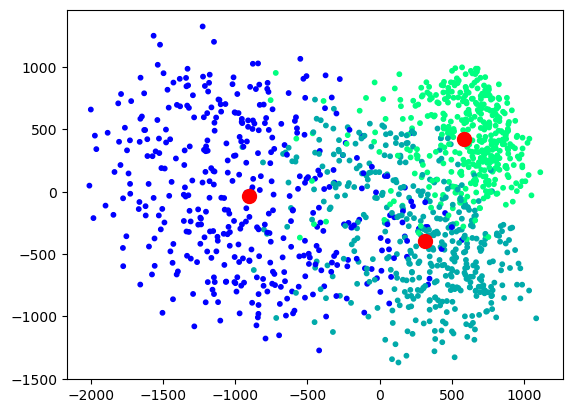

In [60]:
_, p = my_PCA(x_train, 2, True)
z_test = my_PCA_fit(x_test, p=p)


Z_train = my_PCA(x_train, 2)
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test, cmap='winter', s=10)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100)
plt.show()

computing the average distance of theese new clusters from their centroid

In [61]:
z1_test = z_test[y_test == digits[0]]
z2_test = z_test[y_test == digits[1]]
z3_test = z_test[y_test == digits[2]]

mean_distances_test = [mean_distance(z1_test, centroids[0, :]), mean_distance(z2_test, centroids[1, :]), mean_distance(z3_test, centroids[2, :])]

print(f"Cluster n. \t Mean distance \t\t Centroid")
print("-------------------------------------------------")
print(f"#1 \t\t {mean_distances_test[0]:.12f} \t ({centroids[0, 0]:.1f}, {centroids[0, 1]:.1f})")
print(f"#2 \t\t {mean_distances_test[1]:.12f} \t ({centroids[1, 0]:.1f}, {centroids[1, 1]:.1f})")
print(f"#3 \t\t {mean_distances_test[2]:.12f} \t ({centroids[2, 0]:.1f},  {centroids[2, 1]:.1f})")

Cluster n. 	 Mean distance 		 Centroid
-------------------------------------------------
#1 		 721.195337615678 	 (-901.7, -36.3)
#2 		 543.883588515314 	 (310.7, -398.1)
#3 		 368.446289073168 	 (584.9,  425.8)


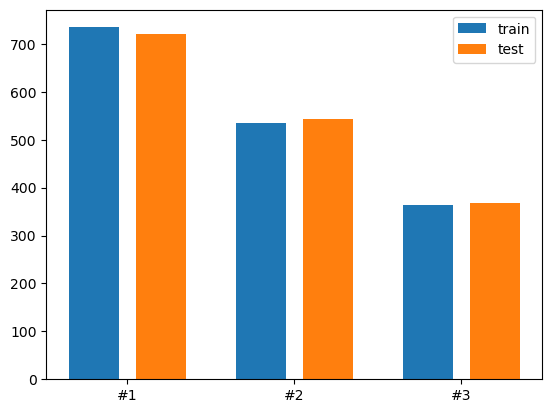

In [62]:
x =  np.array([1,2,3])
plt.bar(x-0.2, mean_distances, width=0.3, label="train")
plt.bar(x+0.2, mean_distances_test, width=0.3, label="test")
plt.legend()
plt.xticks(x, ["#1","#2","#3"])
plt.show()

there is a very small difference in the distances from the centroids, as expected

## PCA Classificator

In [63]:
# This function could easily be extended to more than 2 variables but, since we don't need it, there is no need to implement it
def PCA_classificate(x, centroids):
    distances = [distance(x, c) for c in centroids]

    return distances.index(min(distances))


def can_classify_PCA(x, y_true, digits, centroids):
    predicted = PCA_classificate(x, centroids)

    return digits[predicted] == y_true

### computing the Misclassification Rate

In [64]:
PCA_correct_classifications = 0
for i in range(len(z_test)):
    if can_classify_PCA(z_test[i], y_test[i], digits, centroids):
        PCA_correct_classifications += 1
MR_PCA = 1 - PCA_correct_classifications / len(z_test)

print(f"Total elements ({digits[0]}, {digits[1]}, {digits[2]}): {len(z_test)}")
print(f"Correctly classified elements: {PCA_correct_classifications}")
print(f"MR: {MR_PCA}")

Total elements (0, 6, 9): 1246
Correctly classified elements: 1035
MR: 0.1693418940609952


The previous alg. performs better, not suprisingly, considered that it uses more singular values to obtain a better approxiamtion